In [1210]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal as mvn
from PIL import Image
from scipy.ndimage import rotate

In [1223]:
# importing the MNIST dataset training set 
data = pd.read_csv('MNIST_train.csv',header=None,skiprows=1,dtype={1: float, 2: int})
# importing the test set
test_data = pd.read_csv('MNIST_test.csv', header=None, skiprows=1, dtype={1: 'float', 2: 'int'})
# x_test and y_test
X_test = test_data.iloc[:,3:]
y_test = test_data.iloc[:,2]

In [1224]:
# count of values in first row of X_test
X_test.iloc[0].value_counts()

0
0      668
254     27
198      8
67       4
52       3
      ... 
233      1
255      1
84       1
238      1
207      1
Name: count, Length: 72, dtype: int64

In [1225]:
# peeking at the da
data.head()

,0,1,2,3,4,5,6,7,8,9,...,777,778,779,780,781,782,783,784,785,786
0,0,0.0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2.0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4.0,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1226]:
# checking the proportion of labels
data.iloc[:,2].value_counts()

2
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: count, dtype: int64

In [1227]:
# checking for nulls
data.isnull().sum().value_counts()

0    787
Name: count, dtype: int64

In [1228]:
# Extract the label and pixel values
y_train = data.iloc[:,2]

# Extract X_labels
X_train = data.iloc[:,3:] # Starting from index 3 to skip Unnamed: 0, index, and labels columns

In [1229]:
y_train.head()

0    5
1    0
2    4
3    1
4    9
Name: 2, dtype: int32

In [1230]:
# check the proportions of labels in the dataset
y_train.value_counts()

2
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: count, dtype: int64

## Data Exploration

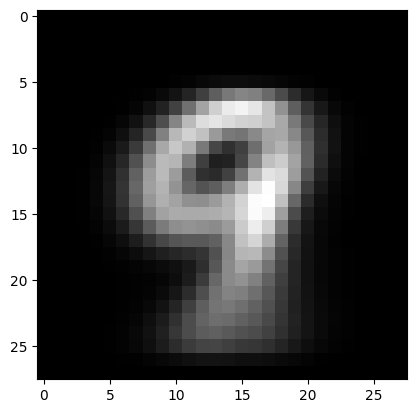

In [1231]:
# average image of a 9
nine = X_train[y_train==9]
nine = nine.mean(axis=0)
nine = nine.values.reshape(28,28)
plt.imshow(nine,cmap='gray')

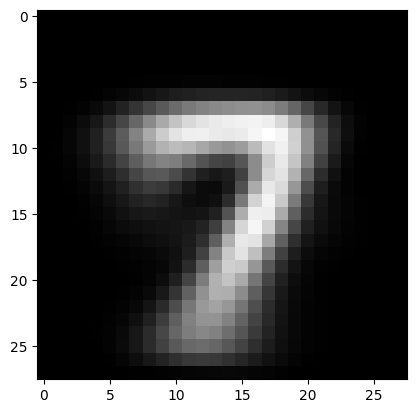

In [1232]:
### average image of 7 
seven = X_train[y_train==7]
seven = seven.mean(axis=0)
seven = seven.values.reshape(28,28)
plt.imshow(seven,cmap='gray')


## Data Transformations

In [1233]:
# # apply min max scaling 
X_train = X_train/255
X_test = X_test/255

In [1234]:
# # change to numpy
X_train = np.array(X_train)
X_test = np.array(X_test)

## KNN Classifier Class

In [1235]:
# # sensitive to magnitude of values (consider min-max normalization)
# # scales horrible with the dimensionality of the dataset

# class KNNClassifier():

#   def fit(self, X, y):
#     self.X=X
#     self.y=y

#   def predict(self, X, K, epsilon =1e-2):

#     N=len(X)
#     y_hat = np.zeros(N)
#     for i in range(N):
#       dist2 = np.sum((self.X-X[i])**2, axis=1)
#       idxt  = np.argsort(dist2)[:K]
#       gamma_k = 1/(np.sqrt(dist2[idxt]+epsilon))
#       y_hat[i] = np.bincount(self.y[idxt], weights= gamma_k).argmax()

#     return y_hat

### Naive Bayes

In [1236]:
class GaussNB():

  def fit(self,X,y,epsilon = 1e-3):

    self.likelihoods = dict()
    self.priors = dict()
    self.K = set(y.astype(int))

    for k in self.K:
      X_k = X[y == k, :]
      if X_k.size == 0:  # Check if X_k is empty
          print(f"Warning: No data points found for class {k}. Skipping.")
          continue
      self.likelihoods[k] = {"mean": X_k.mean(axis=0), "cov": X_k.var(axis=0) + epsilon}
      self.priors[k] = len(X_k) / len(X)

  def predict(self,X):

    N, D = X.shape
    P_hat = np.zeros((N,len(self.K)))

    for k,l in self.likelihoods.items():
      # Apply Bayes Theorem
      P_hat[:,k] = mvn.logpdf(X,l["mean"],l["cov"]) + np.log(self.priors[k])

    return P_hat.argmax(axis=1)


### Bayes Gaussian Model

In [1237]:
class GaussBayes():

  def fit(self,X,y, epsilon =1e-3):
    self.likelihoods = dict()
    self.priors = dict()
    self.K = set(y.astype(int))

    for k in self.K:
      X_k = X[y==k,:]
      N_k, D = X_k.shape
      mu_k = X_k.mean(axis=0)

      self.likelihoods[k] = {"mean": X_k.mean(axis=0),
                             "cov":(1/(N_k-1))*np.matmul((X_k-mu_k).T,X_k-mu_k)+epsilon*np.identity(D)}

      self.priors[k] = len(X_k)/len(X)

  def predict(self,X):
    N,D = X.shape
    P_hat = np.zeros((N,len(self.K)))
    for k,l in self.likelihoods.items():
      P_hat[:,k]=mvn.logpdf(X,l["mean"],l["cov"])+np.log(self.priors[k])

    return P_hat.argmax(axis=1)



### Training the KNN model

In [1238]:
gnb = GaussNB()

In [1239]:
gnb.fit(X_train,y_train)

In [1240]:
gb = GaussBayes()

In [1241]:
gb.fit(X_train,y_train)

### Testing On the Test Set

In [1242]:
# X_test
#X_test=test_data.iloc[:,3:].to_numpy()

# y_test from original dataset
y_test=y_test.to_numpy()

In [1243]:
# proportions of labels in the test set 
pd.Series(y_test).value_counts()

1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
Name: count, dtype: int64

In [1244]:
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [1246]:
# naive bayes was considerably faster than KNN
y_hat_gnb = gnb.predict(X_test)

In [1247]:
# predicts for gaussian bayes
y_hat_gb = gb.predict(X_test)

In [1248]:
def accuracy(y,y_hat):
  return np.mean(y==y_hat)

In [1249]:

# acccuracy for gaussian bayes on 0.5878
accuracy(y_test,y_hat_gnb)


0.7746

In [1250]:
accuracy(y_test,y_hat_gb)
# previous accuracy was 0.7532

0.9108

In [1251]:

def confusion_matrix(y, y_hat):
    # Create a DataFrame initialized with zeros instead of NaN
    cm = pd.DataFrame(0, index=np.unique(y), columns=np.unique(y))
    
    # Increment the appropriate cell for each pair of actual and predicted labels
    for i in range(len(y)):
        cm.loc[y[i], y_hat[i]] += 1

    return cm


In [1252]:
# confusion matrix for naive bayes
confusion_matrix(y_test,y_hat_gnb)


,0,1,2,3,4,5,6,7,8,9
0,887,0,6,3,4,8,23,1,44,4
1,0,1087,3,5,0,1,7,0,31,1
2,19,21,690,45,10,4,92,8,135,8
3,10,32,23,766,3,17,23,16,63,57
4,6,3,9,3,559,10,32,6,34,320
5,26,20,9,89,24,467,23,8,174,52
6,9,12,13,2,3,18,879,0,21,1
7,0,17,9,8,21,1,3,779,28,162
8,8,68,10,26,15,26,8,6,721,86
9,4,8,5,9,28,1,0,21,22,911


In [1253]:
# confusion matrix for gaussian naive bayes
confusion_matrix(y_test,y_hat_gb)

# 93 things were predicted 7 but actually 9

,0,1,2,3,4,5,6,7,8,9
0,951,0,3,7,0,4,4,2,9,0
1,0,1098,8,3,1,0,6,0,19,0
2,8,3,942,17,4,1,3,4,49,1
3,8,0,9,904,1,9,0,5,60,14
4,1,0,13,2,877,0,4,5,12,68
5,7,0,2,40,2,732,12,2,85,10
6,11,2,4,0,5,14,903,0,19,0
7,0,7,12,10,17,1,0,872,16,93
8,9,6,9,23,4,7,3,4,897,12
9,5,5,5,9,11,0,0,20,22,932
